In [1]:
import getpass
import os
import functools
import operator
import json

from typing import Annotated, Literal, Dict, Union, TypedDict, List, Any, Optional, Sequence
from typing_extensions import TypedDict
from dotenv import load_dotenv
from pydantic import BaseModel


from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.output_parsers import JsonOutputParser
from langchain_openai import ChatOpenAI

from langchain_groq import ChatGroq
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent

from IPython.display import Image, display

from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
from langchain_core.pydantic_v1 import BaseModel

Chat-bot code



In [3]:
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("GROQ_API_KEY") 
_set_if_undefined("LANGCHAIN_API_KEY") 
_set_if_undefined("TAVILY_API_KEY") 

# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

Please provide your GROQ_API_KEY ········
Please provide your LANGCHAIN_API_KEY ········
Please provide your TAVILY_API_KEY ········


Search Tool: TavilySearchResults is initialized to provide a search tool that returns a maximum of 5 results.
Python REPL Tool: PythonREPLTool is initialized to allow Python code execution within the agent's environment.

In [5]:
tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
python_repl_tool = PythonREPLTool()

Define Agent Creation: create_agent is a function that takes a language model (llm), a list of tools, and a system prompt to create an AI agent.
Prompt Template: Uses ChatPromptTemplate to define the conversation's initial state and placeholders for future messages.
Agent and Executor: Creates an OpenAI tool agent with the defined tools and prompt, then wraps it in an AgentExecutor for easy execution.

In [8]:

llm = ChatGroq(model="llama-3.1-70b-versatile") 


def create_agent(llm: ChatGroq, tools: list, system_prompt: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

Define Node Behavior: agent_node is a function that takes a state, agent, and name, invokes the agent with the state, and returns the output as a HumanMessag

In [10]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

State Definition: AgentState is a TypedDict that defines the structure of the state, including a sequence of messages and the next step.

In [14]:
# Define the AgentState TypedDict
class AgentState(TypedDict):
    messages: Annotated[Sequence[str], operator.add]  # Using operator.add for message accumulation
    next: str

# Define the members of the conversation
# members = [ 
#     "Sales_Agent",
#     "Product_Search_Agent",
#     "Stock_Check_Agent",
#     "Price_Check_Agent",
#     "Order_Handling_Agent",
#     "Order_Status_Agent",
#     "Delivery_Status_Agent"
# ]

#llm = ChatGroq(model="mixtral-8x7b-32768")  
members = ["Sales_Agent", "Order_Handling_Agent"]
sales_members = ["Product_Search_Agent", "Price_Check_Agent", "Stock_Check_Agent"]
orderhandling_members = ["Order_Status_Agent", "Delivery_Status_Agent"]

options = ["FINISH"] + members + sales_members + orderhandling_members

function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "enum": options,  
            }
        },
        "required": ["next"],
    },
}


global_system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f"following workers: {', '.join(members)}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " If the user query has been resolved, reply with 'FINISHED'."
)

# Sales Agent Supervisor Prompt
sales_agent_prompt = (
    "You are the Sales Agent Supervisor. Route the conversation to the appropriate"
    f"following workers: {', '.join(sales_members)}."
    " agent for handling product search, then price check, and then stock check."
    " When all tasks are completed, select FINISH."
)

# Order Handling Agent Supervisor Prompt
order_handling_prompt = (
    "You are the Order Handling Supervisor. Route the conversation to the appropriate"
    f"following workers: {', '.join(orderhandling_members)}."
    " agent for handling orders, checking order status, or checking delivery status."
    " When all tasks are completed, select FINISH."
)

# Create ChatPromptTemplates
global_system_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", global_system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Select the next members. Options: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

sales_agent_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", sales_agent_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Select the next agent like sales_members for sales-related tasks. Options: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(sales_members),)

order_handling_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", order_handling_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Select the next agent like orderhandling_members for order-related tasks. Options: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(orderhandling_members))


global_supervisor_chain = (
    global_system_prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

sales_agent_chain = (
    sales_agent_prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

order_handling_chain = (
    order_handling_prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)


In [16]:
# Define the individual agents
sales_agent = create_agent(llm, [tavily_tool], "You act as a sales agent, managing product and sales queries, required prices also.")
product_search_agent = create_agent(llm, [tavily_tool], "You search for products based on customer requests.")
stock_check_agent = create_agent(llm, [tavily_tool], "You check stock availability.")
price_check_agent = create_agent(llm, [tavily_tool], "You check the prices of products.")
order_handling_agent = create_agent(llm, [tavily_tool], "You handle orders, from entry to processing, when clicked to cart or selected to buy.")
order_status_agent = create_agent(llm, [tavily_tool], "You check the status of customer orders, when placed the order only.")
delivery_status_agent = create_agent(llm, [tavily_tool], "You check the delivery status of orders once the order is booked only.")

# Create partial functions for each agent node

product_search_agent_node = functools.partial(agent_node, agent=product_search_agent, name="Product_Search_Agent")
stock_check_agent_node = functools.partial(agent_node, agent=stock_check_agent, name="Stock_Check_Agent")
price_check_agent_node = functools.partial(agent_node, agent=price_check_agent, name="Price_Check_Agent")
# order_handling_agent_node = functools.partial(agent_node, agent=order_handling_agent, name="Order_Handling_Agent")
order_status_agent_node = functools.partial(agent_node, agent=order_status_agent, name="Order_Status_Agent")
delivery_status_agent_node = functools.partial(agent_node, agent=delivery_status_agent, name="Delivery_Status_Agent")


workflow = StateGraph(AgentState)


workflow.add_node("Supervisor", global_supervisor_chain)
workflow.add_node("Sales_Agent", sales_agent_chain)
workflow.add_node("Product_Search_Agent", product_search_agent_node)
workflow.add_node("Stock_Check_Agent", stock_check_agent_node)
workflow.add_node("Price_Check_Agent", price_check_agent_node)
workflow.add_node("Order_Handling_Agent", order_handling_chain)
workflow.add_node("Order_Status_Agent", order_status_agent_node)
workflow.add_node("Delivery_Status_Agent", delivery_status_agent_node)


workflow.add_edge(START, "Supervisor")


members_Array = ["Product_Search_Agent", "Price_Check_Agent", "Stock_Check_Agent", "Order_Status_Agent", "Delivery_Status_Agent"]



conditional_map = {
    "Sales_Agent": "Sales_Agent",
    "Order_Handling_Agent": "Order_Handling_Agent",
    "FINISH": END
}
workflow.add_conditional_edges("Supervisor", lambda x: x["next"], conditional_map)

sales_conditional_map = {
    "Product_Search_Agent": "Product_Search_Agent",
    "Price_Check_Agent": "Price_Check_Agent",
    "Stock_Check_Agent": "Stock_Check_Agent",
    "FINISH": "Supervisor"
}
workflow.add_conditional_edges("Sales_Agent", lambda x: x["next"], sales_conditional_map)



order_conditional_map = {
    "Order_Status_Agent": "Order_Status_Agent",
    "Delivery_Status_Agent": "Delivery_Status_Agent",
    "FINISH": "Supervisor"
}
workflow.add_conditional_edges("Order_Handling_Agent", lambda x: x["next"], order_conditional_map)


for member in members_Array:
    # Determine which sub-supervisor the agent should report back to
    if member in ["Product_Search_Agent", "Price_Check_Agent", "Stock_Check_Agent"]:
        workflow.add_edge(member, "Sales_Agent")
    elif member in ["Order_Status_Agent", "Delivery_Status_Agent"]:
        workflow.add_edge(member, "Order_Handling_Agent")

graph = workflow.compile()

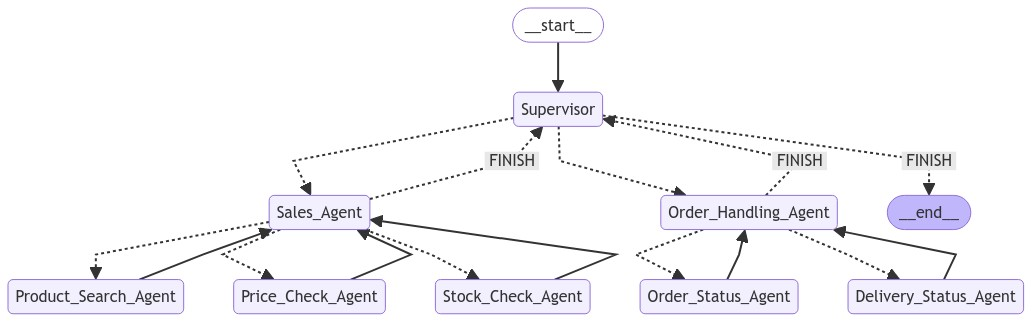

In [17]:
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [26]:
from langchain_core.messages import BaseMessage, HumanMessage

# The input message to be processed by the graph
input_message = {
    "messages": [
        HumanMessage(content="I want to buy 10 hp laptops, deliver to Delhi")
    ]
}

try:
    for state in graph.stream(input_message):
        print(f"Current State: {state}")
        if "__end__" not in state:
            print(state)
            print("----")
except Exception as e:
    print(f"An error occurred: {str(e)}")



Current State: {'Supervisor': {'next': 'Sales_Agent'}}
{'Supervisor': {'next': 'Sales_Agent'}}
----
Current State: {'Sales_Agent': {'next': 'Product_Search_Agent'}}
{'Sales_Agent': {'next': 'Product_Search_Agent'}}
----
-------------------
{'messages': [HumanMessage(content='I want to buy 10 hp laptops, deliver to Delhi')], 'next': 'Product_Search_Agent'}
----------------------------
Current State: {'Product_Search_Agent': {'messages': [HumanMessage(content="Based on the search results, here are some options for buying 10 HP laptops in Delhi:\n\n1. HP World Stores: You can visit HP World Stores in Delhi to purchase HP laptops. They have a wide range of laptops available, and you can check the prices and specifications on their website.\n2. Nehru Place Market: Nehru Place Market in Delhi is a popular destination for buying laptops and other electronic devices. You can find several HP authorized dealers and wholesalers in the market who can provide you with the best deals on HP laptops.\